In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
warm_start = True
dummy_run = True

In [3]:
import torch
from torch import nn
import numpy as np
from PIL import Image
import random
import cv2

import supervision as sv
from supervision import DetectionDataset,Detections
from autodistill_seggpt.train import SegGPTTorchDataset, SegGPTTorchModel
from autodistill_seggpt.colors import RGBSemantic
from autodistill_seggpt.dataset_utils import extract_images_from_dataset

coloring = RGBSemantic

/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from roboflow import login,Roboflow

# login()
# rf = Roboflow()
# project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
# dataset = project.version(5).download("coco-segmentation")

cache_ds = True

if cache_ds:
    dataset_location = "/home/andrewhealey/autodistill-seggpt-1/Yolov5_seg-10"
else:
    rf = Roboflow(api_key="")
    project = rf.workspace("segmentation-yolov5").project("yolov5_seg-tm3yy")
    dataset = project.version(10).download("coco-segmentation")
    dataset_location = dataset.location

train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_location}/train",
    annotations_path=f"{dataset_location}/train/_annotations.coco.json",
    force_masks=True
)


valid_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_location}/valid",
    annotations_path=f"{dataset_location}/valid/_annotations.coco.json",
    force_masks=True
)

In [5]:

if dummy_run:
    print(list(valid_dataset.images.keys())[0])
    train_dataset = valid_dataset = extract_images_from_dataset(valid_dataset,list(valid_dataset.images.keys())[0:1])

new_v1-176-_jpg.rf.929e3255dd394a246af405419c5e4d1d.jpg


In [6]:
device = "cuda"

In [7]:
train_ds = SegGPTTorchDataset(train_dataset, coloring,"cpu")

In [9]:
from autodistill_seggpt.train import save_dataset
save_dataset("dummy_screw",train_ds)

In [ ]:
model = SegGPTTorchModel(coloring).to(device)


new_v1-176-_jpg.rf.929e3255dd394a246af405419c5e4d1d.jpg


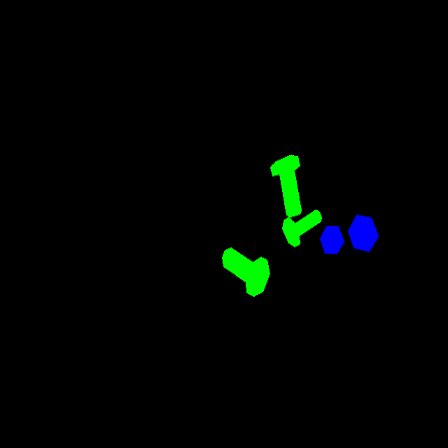

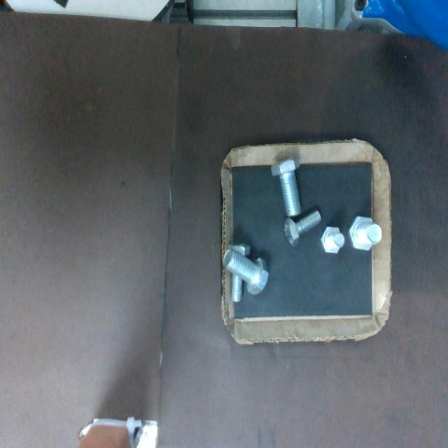

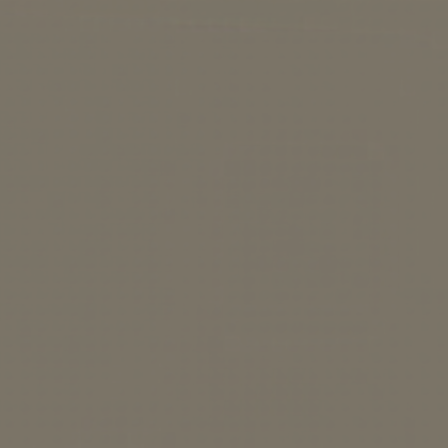

In [ ]:
with torch.no_grad():

    valid_ds = SegGPTTorchDataset(valid_dataset,coloring,device)

    print(list(valid_dataset.images.keys())[0])
    imgs,gt_masks = valid_ds[0]

    gt_mask = Image.fromarray(model.postprocess(gt_masks).cpu().numpy().astype(np.uint8))
    gt_mask.show()
    gt_mask.save("gt_mask.png")

    gt_img = Image.fromarray((model.postprocess(imgs).cpu().numpy()).astype(np.uint8))
    gt_img.show()
    gt_img.save("gt_img.png")

    if warm_start:
        model.reference_img = nn.Parameter(imgs.unsqueeze(0))
        # model.reference_mask = nn.Parameter(gt_masks.unsqueeze(0))

    test_dataset = DetectionDataset(classes=[],images={
        "test": cv2.imread("/home/andrewhealey/painter/screws/test.jpg")
    },annotations={
        "test": Detections.empty()
    })
    test_ds = SegGPTTorchDataset(test_dataset,coloring,device)

    pred_mask = torch.clip(model(test_ds[0][0]),0,255)

    Image.fromarray(pred_mask.cpu().numpy().astype(np.uint8)).show()

In [ ]:
cache_model = False
if cache_model:
    state_dict = torch.load("model.pth")
    model.load_state_dict(state_dict)


In [ ]:
lr = 2e-1
epochs = 10_000
log_period = 20
wandb_period = 3
batch_size = 1

import wandb
wandb.login()
run = wandb.init(
# Set the project where this run will be logged
project="seggpt-context-tuning",
# Track hyperparameters and run metadata
config={
    "learning_rate": lr,
    "epochs": epochs,
})

# use random permutation of dataset

last_pred = None
last_gt = None

from tqdm import tqdm

def train():
    curr_iters = 0

    optimizer = model.get_optimizer(lr)

    for epoch in range(epochs):
        # shuffle dataset
        rand_perm = np.random.permutation(len(train_ds))

        for idx in tqdm(rand_perm):
            img,gt_mask = train_ds[idx]

            img = img.to(device)
            gt_mask = model.postprocess(gt_mask.to(device))

            # forward pass
            pred_mask = model(img)

            global last_pred, last_gt
            last_pred = pred_mask.detach()
            last_gt = gt_mask.detach()

            loss = model.loss_fn(pred_mask,gt_mask)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            if curr_iters % batch_size == 0:
                optimizer.step()

            if curr_iters % log_period == 0:
                print(f"Epoch {epoch}, Iter {curr_iters}, Loss {loss.detach().cpu().item()}")
            if curr_iters % wandb_period == 0:
                wandb.log({
                    "loss": loss.detach().cpu().item(),
                    "pred_mask": wandb.Image(Image.fromarray(torch.clip(last_pred,0,255).cpu().numpy().astype(np.uint8))),
                    "gt_mask": wandb.Image(Image.fromarray(torch.clip(last_gt,0,255).cpu().numpy().astype(np.uint8))),
                    "ref_img": wandb.Image(Image.fromarray(torch.clip(model.postprocess(model.reference_img[0].detach()),0,255).cpu().numpy().astype(np.uint8))),
                    "ref_mask": wandb.Image(Image.fromarray(torch.clip(model.postprocess(model.reference_mask[0].detach()),0,255).cpu().numpy().astype(np.uint8))),
                }, step=curr_iters)
            curr_iters += 1

train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0, Iter 0, Loss 114.63680780756611


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Epoch 20, Iter 20, Loss 1.948777709602979


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 40, Iter 40, Loss 1.9128139558690265


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 60, Iter 60, Loss 1.9049759818943053


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 80, Iter 80, Loss 1.9022227001556327


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 100, Iter 100, Loss 1.9008123429310244


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 120, Iter 120, Loss 1.899714704561276


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 140, Iter 140, Loss 1.8986197439830257


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 160, Iter 160, Loss 1.8976159760117086


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 180, Iter 180, Loss 1.8968094500353136


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 200, Iter 200, Loss 1.8961218420289805


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 220, Iter 220, Loss 1.895479400184792


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 240, Iter 240, Loss 1.8948615473036927


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 260, Iter 260, Loss 1.8942940845828322


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 280, Iter 280, Loss 1.8938066225226307


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 300, Iter 300, Loss 1.8933898385975358


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 320, Iter 320, Loss 1.89336077916701


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 340, Iter 340, Loss 1.8927650133056058


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 360, Iter 360, Loss 1.8927358843205448


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 380, Iter 380, Loss 1.8921811796283592


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 400, Iter 400, Loss 1.895743919674868


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 420, Iter 420, Loss 1.8921055967716827


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 440, Iter 440, Loss 1.8917655047515365


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 460, Iter 460, Loss 1.8911974801737428


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 480, Iter 480, Loss 1.8914606454268164


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 500, Iter 500, Loss 1.8908169515632411


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 520, Iter 520, Loss 1.8905813189845475


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 540, Iter 540, Loss 1.8910518117949566


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 560, Iter 560, Loss 1.8904864644440742


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 580, Iter 580, Loss 1.8899851090251036


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 600, Iter 600, Loss 1.8897292191792905


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 620, Iter 620, Loss 1.8898196747841036


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 640, Iter 640, Loss 1.8892916497196959


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 660, Iter 660, Loss 1.8891237490526736


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 680, Iter 680, Loss 1.9200450781950946


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 700, Iter 700, Loss 1.8986787814986035


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 720, Iter 720, Loss 1.8948975865452204


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 740, Iter 740, Loss 1.8931664747578325


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 760, Iter 760, Loss 1.8917894222182965


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 780, Iter 780, Loss 1.8904530816578038


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 800, Iter 800, Loss 1.889531194205796


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 820, Iter 820, Loss 1.8894823168073729


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 840, Iter 840, Loss 1.8886169497895053


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 860, Iter 860, Loss 1.8881828532478284


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 880, Iter 880, Loss 1.8878064907495984


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 900, Iter 900, Loss 1.8875147173791271


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 920, Iter 920, Loss 1.887282533972301


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 940, Iter 940, Loss 1.886912352820555


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 960, Iter 960, Loss 1.8865676597582473


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 980, Iter 980, Loss 1.8867238445421224


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1000, Iter 1000, Loss 1.8859473392340023


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1020, Iter 1020, Loss 1.8860246421349465


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1040, Iter 1040, Loss 1.885354659287412


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1060, Iter 1060, Loss 1.8858328793399355


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 1080, Iter 1080, Loss 1.884767405918221


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1100, Iter 1100, Loss 1.8851696105017988


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1120, Iter 1120, Loss 1.8844960577650591


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1140, Iter 1140, Loss 1.8846051944919275


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1160, Iter 1160, Loss 1.883899187180034


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1180, Iter 1180, Loss 1.8837733577720253


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1200, Iter 1200, Loss 1.8845074846435323


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1220, Iter 1220, Loss 1.8840395988425136


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1240, Iter 1240, Loss 1.883388161339955


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1260, Iter 1260, Loss 1.8835237481092983


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1280, Iter 1280, Loss 1.8834756348081


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 1300, Iter 1300, Loss 1.8829423088662172


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 1320, Iter 1320, Loss 1.8827028681421059


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1340, Iter 1340, Loss 1.8827916166250078


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1360, Iter 1360, Loss 1.8843255775851664


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1380, Iter 1380, Loss 1.8850687660532477


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1400, Iter 1400, Loss 1.882688494628583


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1420, Iter 1420, Loss 1.8820557062699956


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1440, Iter 1440, Loss 1.8819724666244957


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1460, Iter 1460, Loss 1.8820921455298796


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1480, Iter 1480, Loss 1.881858631948347


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1500, Iter 1500, Loss 1.8816307389090026


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1520, Iter 1520, Loss 1.8825318021534463


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Epoch 1540, Iter 1540, Loss 1.8816318922144184


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Epoch 1560, Iter 1560, Loss 1.8831975965380492


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1580, Iter 1580, Loss 1.881388669775545


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 1600, Iter 1600, Loss 1.8815733763247555


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Epoch 1620, Iter 1620, Loss 1.8812435594493029


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1640, Iter 1640, Loss 1.8811784744623508


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 1660, Iter 1660, Loss 1.881389305485463


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Epoch 1680, Iter 1680, Loss 1.8810328335698876


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 1700, Iter 1700, Loss 1.88095001151372


  0%|          | 0/1 [00:00<?, ?it/s]

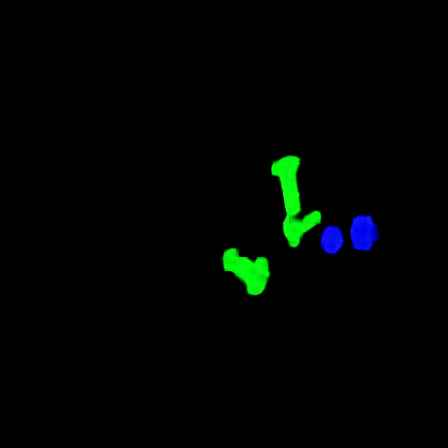

In [ ]:
with torch.no_grad():
    Image.fromarray(torch.clip(last_pred,0,255).cpu().numpy().astype(np.uint8)).show()

In [ ]:
model.zero_grad(set_to_none=True)

import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

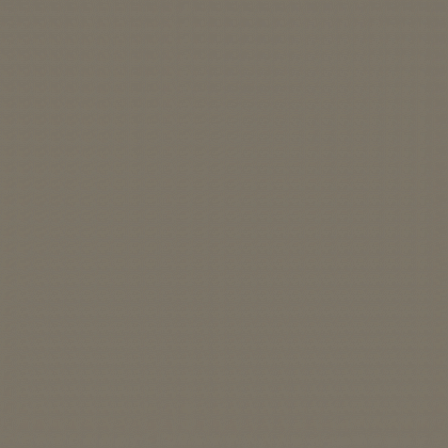

In [ ]:
Image.fromarray(torch.clip(model.postprocess(model.reference_img[0]),0,255).detach().cpu().numpy().astype(np.uint8))

pred_mask torch.Size([448, 448, 3])


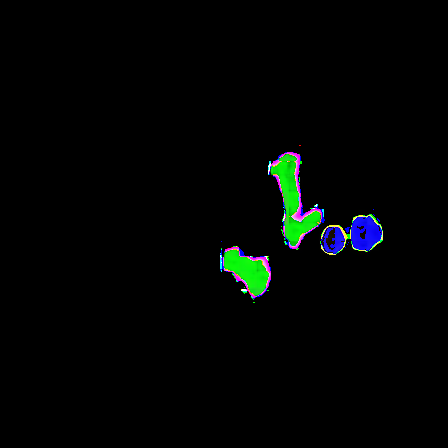

In [ ]:
with torch.no_grad():

    valid_ds = SegGPTTorchDataset(valid_dataset,coloring,device)

    rand_sample = random.randint(0,len(valid_ds)-1)

    imgs,gt_masks = valid_ds[rand_sample]

    model.reference_img = nn.Parameter(imgs[None,...])
    model.reference_mask = nn.Parameter(gt_masks[None,...])

    pred_mask = model(imgs)

    # pred_mask = torch.einsum('hwc->chw',pred_mask)

    print('pred_mask',pred_mask.shape)

Image.fromarray(pred_mask.cpu().detach().numpy().astype(np.uint8))

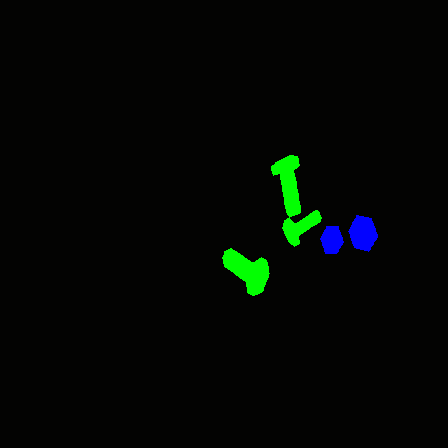

In [ ]:
a = pred_mask.cpu().detach().numpy().astype(np.uint8)
b = gt_masks.cpu().detach().numpy().astype(np.uint8)

Image.fromarray(1-b)

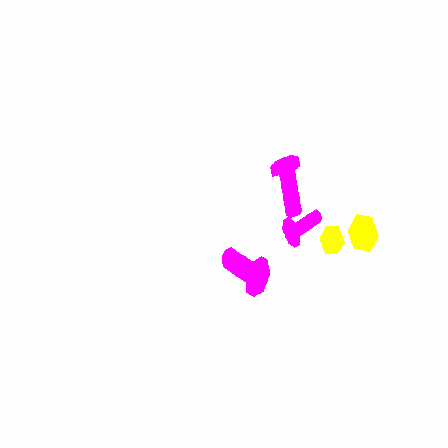

In [ ]:
Image.fromarray(gt_masks.detach().cpu().numpy().astype(np.uint8))